In [85]:
# import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# **Using Census Data from the American Community Survey in NY to predict the 'Average Starting Salary', 'Standard Deviation', and 'Average Raise Rate' in 2018 for Physician Assistants (PAs).**
## **Assumptions:** Starting salary is normally distributed and earnings grow at a constant percentage each year for all PAs.
## **Data Source:** https://www.census.gov/programs-surveys/acs/data/pums.html

### **Note about data:** The data is available in 1 year and 5 year Public Use Microdata Sample (PUMS), for this project the 1 year 2018 ACS PUMS and 5 year 2014-2018 PUMS was used.

# Part 1: Use 1 year survey to calculate average income and standard deviation

### Starting with the 1 year 2018 ACS PUMS data

* load the data and create a dataframe
* drop all columns except age, income and columns related to hours and weeks worked
* Summary stats for dataframe
* Use age to try and select PAs most likely to be early career or just starting (subjective)
* trim oultiers and remove errors (subjective)
* calculate 'Average Income' and 'Standard Deviation'
* calculate, 'Margin of Error', 'Confidence Intervals' (90% and 95%)

In [189]:
# load data and create dataframe
# from the PUMS documentation New York State code is 36 and p is for personal
pums_1yr = pd.read_csv('psam_p36.csv')

# print out the shape of the full dataframe
pums_1yr.shape

(196967, 286)

In [190]:
# print out first 5 rows
pums_1yr.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2018GQ0000012,2,1,3802,1,36,1013097,145,26,...,146,146,21,24,266,263,21,146,265,144
1,P,2018GQ0000040,2,1,2702,1,36,1013097,43,21,...,6,42,43,7,40,6,43,40,42,6
2,P,2018GQ0000060,2,1,2001,1,36,1013097,88,18,...,88,163,161,162,87,12,162,88,87,88
3,P,2018GQ0000081,2,1,2401,1,36,1013097,109,85,...,17,15,111,107,17,196,109,200,198,111
4,P,2018GQ0000103,2,1,1400,1,36,1013097,83,19,...,81,12,80,154,12,80,12,83,152,154


In [191]:
# columns for age, salary, and those related to amount worked
keep = [
    'AGEP',    # AGEP: Age
    'WAGP',    # WAGP: Wages or salary income for the past 12 months
    'WKHP',    # WKHP: Usual hours worked per week past 12 months
    'WKW',     # WKW:  Weeks worked past 12 months, 1: 50-52, 2: 48-49, 3: 40-47, 4: 27-39, 5: 14-26, 6: less than 14
]

In [192]:
# PA occupation code
pa_code = 3110

In [194]:
# create a new dataframe of PAs with columns from above
pa_1yr = pums_1yr[pums_1yr['OCCP'] == pa_code]
pa_1yr = pa_1yr[keep]

# look at shape of new dataframe
pa_1yr.shape

(148, 4)

In [195]:
# look at first 5 rows of new dataframe
pa_1yr.head()

,AGEP,WAGP,WKHP,WKW
11393,28,110000.0,40.0,1.0
13078,42,65000.0,30.0,1.0
15427,27,110000.0,40.0,1.0
16218,26,95000.0,45.0,1.0
17155,31,120000.0,40.0,1.0


In [197]:
def clean_income_work(df):
    """
    Remove older workers above 33, remove part time workers working under 36 hours per week,
    remove workers who worked less than 27 weeks.
    
    df: Pandas DataFrame
    
    return: DataFrame, cleaned to remove older and part time workers
    """
    # Copy dataframe
    df = df.copy()
    
    # research shows 50% of PA graduates are between 25 - 33 years old
    # remove PAs over the age of 33
    df = df[df['AGEP'] <= 33]

    # from data dictionary WKHP is usual hours worked per week
    # remove hours under 36 per week, to remove part time
    df = df[df['WKHP'] >= 36]

    # from data dictionary WKW weeks worked during the past 12 months
    # categorical, values 5 and over represent less than 27 weeks worked
    df = df[df['WKW'] < 5]
    
    return df

# remove older and part time workers and print out shape
pa_1yr = clean_income_work(pa_1yr)
pa_1yr.shape

(47, 4)

In [198]:
# Summary stats of remaining observations
pa_1yr.describe()

,AGEP,WAGP,WKHP,WKW
count,47.000000,47.000000,47.000000,47.000000
mean,29.191489,103914.893617,42.978723,1.276596
std,2.533586,39516.001045,7.203530,0.826257
min,25.000000,24000.000000,36.000000,1.000000
25%,27.000000,90000.000000,40.000000,1.000000
50%,29.000000,100000.000000,40.000000,1.000000
75%,31.500000,121000.000000,45.000000,1.000000
max,33.000000,200000.000000,80.000000,4.000000


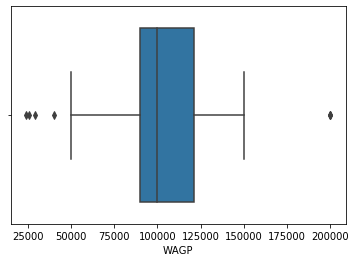

In [199]:
# Box plot of Income, use to trim outliers
sns.boxplot(pa_1yr['WAGP']);

In [200]:
def trim_outliers(df, low, high):
    """
    Remove low and upper outliers
    
    df: Pandas DataFrame
    low: int, used to trim lower outliers
    high: int, used to trim upper outliers
    
    return: DataFrame
    """
    # Copy df
    df = df.copy()
    
    # remove upper and lower outliers in income
    df = df[(df['WAGP'] >= low) & (df['WAGP'] <= high)]
    
    return df

# removed outliers and print shape
pa_1yr = trim_outliers(pa_1yr, 50000, 150000)
pa_1yr.shape

(40, 4)

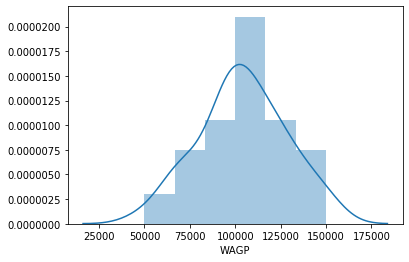

In [201]:
# Income distribution after removing outliers
sns.distplot(pa_1yr['WAGP']);

In [202]:
# look at value counts of AGE after cleaning
pa_1yr['AGEP'].value_counts()

28    7
30    6
27    6
32    5
31    5
33    4
26    4
25    2
29    1
Name: AGEP, dtype: int64

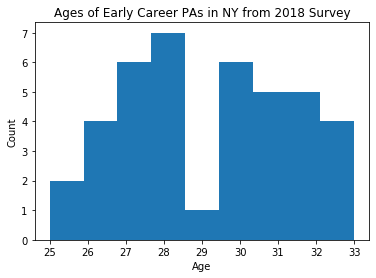

In [209]:
plt.hist(pa_1yr['AGEP'], bins=9)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Ages of Early Career PAs in NY from 2018 Survey")
plt.show();

### **Calculate Average Income and Standard Deviation**

In [42]:
# Calculate the average income
mean_income = pa_1yr['WAGP'].sum() / len(pa_1yr['WAGP'])

# calculate the variance in PA incomes
var = sum((x-mean_income)**2 for x in pa_1yr['WAGP']) / len(pa_1yr['WAGP'])

# use variance to calculate the standard deviation
std = np.sqrt(var)

# check above calculations using numpy
assert np.isclose(mean_income, np.mean(pa_1yr['WAGP'])) == True  # check average income
assert np.isclose(var, np.var(pa_1yr['WAGP'])) == True           # check variance calculation
assert np.isclose(std, np.std(pa_1yr['WAGP'])) == True           # check standard deviation

# print out the formated average income
print(f"The average salary for early career PA's in NY in 2018 is ${mean_income:,.2f}")

# print out the formated standard deviation
print(f"The standard deviation in salary for early career PA's in NY in 2018 is ${std:,.2f}")

The average salary for early career PA's in NY in 2018 is $104,125.00
The standard deviation in salary for early career PA's in NY in 2018 is $23,439.48


In [219]:
def conf_interval(mean, std, z_score, n):
    """
    given a mean, std, z-score, and sample size n, calculate the margin of error and confidence interval
    
    mean: float, sample mean
    std: float, sample standard deviation
    z: float, z-score
    n: int, sample size
    
    return: none, print out results
    """
    # use provided z-score and sample size n to calculate margin of error and interval
    z = z_score
    margin_of_error = z * ( std / np.sqrt(n) )
    low = mean - margin_of_error
    high = mean + margin_of_error
    
    # print average, margin of error, and confidence interval
    print(f"The average salary for early career PA's in NY in 2018 is ${mean:,.2f}")
    print(f'The margin of error is ${margin_of_error:,.2f}')
    print(f'The confidence interval is ${low:,.2f} - ${high:,.2f}\n\n')

# use confidence interval function for 90%
print('For 90% confidence:')
conf_interval(mean_income, std, 1.645, len(pa_1yr))

# use confidence interval function for 95%
print('For 95% confidence:')
conf_interval(mean_income, std, 1.96, len(pa_1yr))

For 90% confidence:
The average salary for early career PA's in NY in 2018 is $104,125.00
The margin of error is $6,096.55
The confidence interval is $98,028.45 - $110,221.55


For 95% confidence:
The average salary for early career PA's in NY in 2018 is $104,125.00
The margin of error is $7,263.97
The confidence interval is $96,861.03 - $111,388.97




# Part 2: Use 5 year survey to calculate raise rate over time

In [2]:
# 5 year survey is a very large file, read it in in chuncks
df_chunk = pd.read_csv('psam_p36_5yr.csv', chunksize=50000, low_memory=False)

# inistialize list to append chuncks
chunk_list = []

# loop through chunks and append them all into chunk_list
for chunk in df_chunk:
    chunk_list.append(chunk)

# concat the elements of the chunk_list into one Pandas DataFrame
pums_5yr = pd.concat(chunk_list)

# print out the shape of the new DataFrame
pums_5yr.shape

(981674, 286)

In [134]:
# due to data size, eliminated un-needed data in excel before loading
pa_5yr = pd.read_csv('pa_ny_5yr.csv')

# Print out shape of Filtered DataFrame
pa_5yr.shape

(538, 7)

In [135]:
# print out the first 5 rows
pa_5yr.head()

,SERIALNO,AGEP,WAGP,WKHP,WKW,WRK,OCCP
0,2014000013261,55,6000,40.0,6.0,1.0,3110
1,2014000016657,53,157000,48.0,1.0,1.0,3110
2,2014000021103,26,103000,48.0,1.0,1.0,3110
3,2014000062989,26,83000,40.0,1.0,1.0,3110
4,2014000081043,27,27000,36.0,4.0,1.0,3110


In [136]:
# first 4 characters of 'SERIALNO' appear to be the year of the survey
pa_5yr['SERIALNO'] = pa_5yr['SERIALNO'].apply(lambda x: x[:4])

In [137]:
# Split the Filtered DataFrame into multiple DataFrames by year of survey
pa_2014 = pa_5yr[pa_5yr['SERIALNO'] == '2014']
pa_2015 = pa_5yr[pa_5yr['SERIALNO'] == '2015']
pa_2016 = pa_5yr[pa_5yr['SERIALNO'] == '2016']
pa_2017 = pa_5yr[pa_5yr['SERIALNO'] == '2017']
pa_2018 = pa_5yr[pa_5yr['SERIALNO'] == '2018']

# Print out the shapes of each of the new DataFrames 
print(pa_2014.shape, pa_2015.shape, pa_2016.shape, pa_2017.shape, pa_2018.shape)

(97, 7) (84, 7) (91, 7) (118, 7) (148, 7)


In [138]:
# clean yearly DataFrames to remove, older and part time workers
pa_2014 = clean_income_work(pa_2014)
pa_2015 = clean_income_work(pa_2015)
pa_2016 = clean_income_work(pa_2016)
pa_2017 = clean_income_work(pa_2017)
pa_2018 = clean_income_work(pa_2018)

In [139]:
# look at the new shapes of each DataFrame
print(pa_2014.shape, pa_2015.shape, pa_2016.shape, pa_2017.shape, pa_2018.shape)

(32, 7) (24, 7) (27, 7) (40, 7) (47, 7)


In [142]:
# set low and high values to trim outliers
low = 50000
high = 150000

# trim outliers from cleaned DataFrame
pa_2014 = trim_outliers(pa_2014, low, high)
pa_2015 = trim_outliers(pa_2015, low, high)
pa_2016 = trim_outliers(pa_2016, low, high)
pa_2017 = trim_outliers(pa_2017, low, high)
pa_2018 = trim_outliers(pa_2018, low, high)

In [143]:
# look at the new shapes of each DataFrame
print(pa_2014.shape, pa_2015.shape, pa_2016.shape, pa_2017.shape, pa_2018.shape)

(27, 7) (21, 7) (24, 7) (34, 7) (40, 7)


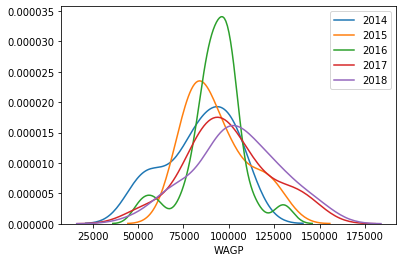

In [144]:
# Income distributions after removing outliers
sns.distplot(pa_2014['WAGP'], hist=False, label='2014')
sns.distplot(pa_2015['WAGP'], hist=False, label='2015')
sns.distplot(pa_2016['WAGP'], hist=False, label='2016')
sns.distplot(pa_2017['WAGP'], hist=False, label='2017')
sns.distplot(pa_2018['WAGP'], hist=False, label='2018')
plt.legend()
plt.show();

In [168]:
# create empty list that will hold mean incomes from each survey year
means = []

# calculate the mean income from each year and add it to the means list
means.append(np.mean(pa_2014['WAGP']))
means.append(np.mean(pa_2015['WAGP']))
means.append(np.mean(pa_2016['WAGP']))
means.append(np.mean(pa_2017['WAGP']))
means.append(np.mean(pa_2018['WAGP']))

# print the mean incomes for each year
for m in means: print(f'${m:,.2f}')

$84,037.04
$93,095.24
$92,416.67
$98,941.18
$104,125.00


In [153]:
# create fucntion to calculate Compound Annual Growth Rate
def cagr(start_value, end_value, n):
    """
    Calculate the average growth rate given a starting value and an ending value over n periods
    
    start_value: float, first value
    end_value: float, ending value
    n: int, number of periods
    
    return: float, average growth rate over n periods 
    """
    return (end_value / start_value) ** (1 / (n - 1)) - 1

In [174]:
# get the average constant growth rate from 2014 to 2018 using 2014 and 2018 mean income
const_rate = cagr(means[0], means[-1], len(means))

# use contant rate to calculate the future value of 2014 mean income and make sure it matches 2018
assert (means[0] * (1 + const_rate) ** (len(means)-1)) == means[-1]

# print out the result
print(f'Average raise rate: {const_rate:.2%}')

Average raise rate: 5.50%


# **Part 3:** Use Raise Rate and Average Income from 2018 to Predict 2020 Income

In [175]:
# Create a future value function
def future_value(starting_value, rate, n):
    """
    Get the future value of a starting amount given a rate and n periods
    
    starting_value: float
    rate: float
    n: int
    
    return: float, future value amount based on starting value, rate, and n periods
    """
    return starting_value * (1 + rate) ** n

In [178]:
# set up variables needed to calculate future value and predict 2020 mean income
mean_2018 = means[-1]    # last mean income from list of means is 2018
n = 2020 - 2018          # number of years = n

# use 2018 mean and n years to predict 2020 mean income
pred_2020 = future_value(mean_2018, const_rate, n)

# print out prediction
print(f"The average salary for early career PA's in NY in 2020 is predictied to be ${pred_2020:,.2f}")

The average salary for early career PA's in NY in 2020 is predictied to be $115,903.66


In [220]:
# Use std and n from 2018 with predicted 2020 income to create 2020 margin of error and confidence intervals
print("2020 margin of error and 90% confidence interval")
conf_interval(pred_2020, std, 1.645, len(pa_1yr))

print("2020 margin of error and 95% confidence interval")
conf_interval(pred_2020, std, 1.96, len(pa_1yr))

2020 margin of error and 90% confidence interval
The average salary for early career PA's in NY in 2018 is $115,903.66
The margin of error is $6,096.55
The confidence interval is $109,807.11 - $122,000.21


2020 margin of error and 95% confidence interval
The average salary for early career PA's in NY in 2018 is $115,903.66
The margin of error is $7,263.97
The confidence interval is $108,639.69 - $123,167.63


